# Data Modeling with Logistic Regression model

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import pandas as pd
import numpy as np

from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from category_encoders import WOEEncoder, TargetEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.preprocessing import PolynomialFeatures as Poly

from mlxtend.evaluate import feature_importance_permutation

from mlxtend.feature_extraction import PrincipalComponentAnalysis
from mlxtend.preprocessing import standardize

from mlxtend.feature_extraction import RBFKernelPCA as KPCA
from pyearth import Earth

from mlxtend.plotting import plot_pca_correlation_graph

# from umap import UMAP

import warnings
warnings.filterwarnings("ignore")

In [2]:
def stringify(data):
    if type(data) != pd.core.frame.DataFrame:
        X = pd.DataFrame(data)
    else:
        X = data
        
    for c in X.columns.tolist():
        X[c] = X[c].astype(str)
#     X = X.applymap(str)
    return X

objectify = FunctionTransformer(func = stringify, check_inverse = False, validate=False)
binner = KBinsDiscretizer(n_bins = 10, encode = 'ordinal')
poly = Poly(degree=3)
encoder = WOEEncoder()

In [3]:
df = pd.read_csv('/Users/davidwalkup/ds-course/projects/Mod3/Seattle_Terry_Stops/data/Terry_Stops_added_features.csv')

In [4]:
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Sector,Beat,subject_age_groups,stop_resolution,arrest_flag,weapon_present,officer_gender,officer_race,subject_race,subject_gender
0,-,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,...,O,O2,7,3,0,0,0,5,5,0
1,-,-1,20150000001670,32260,Field Contact,None,7539,1963,M,White,...,-,-,7,1,0,0,0,1,3,2
2,-,-1,20150000002451,46430,Field Contact,None,7591,1985,M,Hispanic or Latino,...,-,-,7,1,0,0,0,2,3,2
3,-,-1,20150000002815,51725,Field Contact,None,7456,1979,M,White,...,-,-,7,1,0,0,0,1,3,2
4,-,-1,20150000002815,51727,Field Contact,None,7456,1979,M,White,...,-,-,7,1,0,0,0,1,3,2


In [5]:
df.columns

Index(['Subject Age Group', 'Subject ID', 'GO / SC Num', 'Terry Stop ID',
       'Stop Resolution', 'Weapon Type', 'Officer ID', 'Officer YOB',
       'Officer Gender', 'Officer Race', 'Subject Perceived Race',
       'Subject Perceived Gender', 'Reported Date', 'Reported Time',
       'Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad',
       'Arrest Flag', 'Frisk Flag', 'Precinct', 'Sector', 'Beat',
       'subject_age_groups', 'stop_resolution', 'arrest_flag',
       'weapon_present', 'officer_gender', 'officer_race', 'subject_race',
       'subject_gender'],
      dtype='object')

In [6]:
df['stop_reso_arrest'] = 0

In [7]:
idx = df['Stop Resolution'] == 'Arrest'
df['stop_reso_arrest'].loc[idx] = 1

In [8]:
df['stop_reso_arrest'].value_counts()

0    29820
1     9577
Name: stop_reso_arrest, dtype: int64

In [9]:
df['Stop Resolution'].value_counts()

Field Contact               15186
Offense Report              13757
Arrest                       9577
Referred for Prosecution      727
Citation / Infraction         150
Name: Stop Resolution, dtype: int64

In [10]:
target = 'stop_reso_arrest'

In [11]:
df['Reported Time'].agg(['min', 'max'])

min    00:00:00
max    23:59:43
Name: Reported Time, dtype: object

In [12]:
df.shape

(39397, 32)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39397 entries, 0 to 39396
Data columns (total 32 columns):
Subject Age Group           39397 non-null object
Subject ID                  39397 non-null int64
GO / SC Num                 39397 non-null int64
Terry Stop ID               39397 non-null int64
Stop Resolution             39397 non-null object
Weapon Type                 39397 non-null object
Officer ID                  39397 non-null int64
Officer YOB                 39397 non-null int64
Officer Gender              39397 non-null object
Officer Race                39397 non-null object
Subject Perceived Race      39397 non-null object
Subject Perceived Gender    39397 non-null object
Reported Date               39397 non-null object
Reported Time               39397 non-null object
Initial Call Type           39397 non-null object
Final Call Type             39397 non-null object
Call Type                   39397 non-null object
Officer Squad               38871 non-null obj

In [14]:
import datetime
df['hour'] = pd.to_datetime(df['Reported Time'], format='%H:%M:%S').dt.hour

In [15]:
df['hour'].value_counts()

18    2486
2     2256
19    2218
17    2146
3     2121
1     1948
16    1882
23    1865
15    1845
14    1757
0     1723
22    1629
11    1603
13    1585
10    1518
21    1375
12    1329
5     1268
9     1243
4     1204
20    1169
8     1110
7     1087
6     1030
Name: hour, dtype: int64

In [16]:
a=39397
b=9577
a/(a+b)

0.8044472577285907

In [17]:
df.loc[(df['stop_reso_arrest'] == 0) & (df['Arrest Flag'] == 'Y')]

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,subject_age_groups,stop_resolution,arrest_flag,weapon_present,officer_gender,officer_race,subject_race,subject_gender,stop_reso_arrest,hour
39215,56 and Above,7730562924,20190000284542,9281278574,Referred for Prosecution,-,8643,1989,F,White,...,6,4,1,0,1,1,1,0,0,13


In [18]:
df.loc[(df['stop_reso_arrest'] == 1) & (df['Arrest Flag'] == 'Y')]

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,subject_age_groups,stop_resolution,arrest_flag,weapon_present,officer_gender,officer_race,subject_race,subject_gender,stop_reso_arrest,hour
1127,-,8273276997,20190000204158,8273686053,Arrest,-,7428,1963,M,Hispanic or Latino,...,7,3,1,0,0,2,1,0,1,16
1144,-,8355337122,20190000229094,8355333909,Arrest,-,8623,1991,M,White,...,7,3,1,0,0,1,2,0,1,10
1148,-,8926195570,20190000279716,8927975747,Arrest,Fire/Incendiary Device,7797,1986,M,White,...,7,3,1,1,0,1,3,0,1,1
1193,-,10511918431,20190000361510,10512053462,Arrest,-,8405,1993,M,White,...,7,3,1,0,0,1,1,0,1,17
1208,-,8613729887,20190000257632,8613721148,Arrest,-,8608,1994,M,Hispanic or Latino,...,7,3,1,0,0,2,2,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39378,56 and Above,8301438958,20190000208799,8301499855,Arrest,-,8644,1995,M,Two or More Races,...,6,3,1,0,0,3,5,0,1,23
39381,56 and Above,8595463249,20190000242578,8596236051,Arrest,-,7634,1977,M,White,...,6,3,1,0,0,1,1,0,1,19
39387,56 and Above,9587645130,20190000288157,9587776187,Arrest,-,8601,1994,F,Two or More Races,...,6,3,1,0,1,3,1,1,1,0
39389,56 and Above,10076866529,20190000329876,10104103280,Arrest,-,8609,1997,M,Two or More Races,...,6,3,1,0,0,3,2,0,1,4


In [114]:
df['Call Type'].value_counts()

911                              16955
-                                12686
ONVIEW                            6880
TELEPHONE OTHER, NOT 911          2666
ALARM CALL (NOT POLICE ALARM)      205
PROACTIVE (OFFICER INITIATED)        2
TEXT MESSAGE                         2
SCHEDULED EVENT (RECURRING)          1
Name: Call Type, dtype: int64

In [118]:
used_cols

['Officer ID',
 'Final Call Type',
 'Officer Squad',
 'Frisk Flag',
 'Precinct',
 'Sector',
 'Beat',
 'subject_age_groups',
 'weapon_present',
 'officer_gender',
 'officer_race',
 'subject_gender',
 'hour']

In [134]:
excluded_cols = ['arrest_flag', 'Arrest Flag',
                 'stop_reso_arrest', 'stop_resolution', 'Stop Resolution',
                 'Subject ID',
                 'Subject Age Group', 'GO / SC Num', 'Terry Stop ID', 
                 'Officer Gender', 'Officer Race', 'Subject Perceived Race', 'Subject Perceived Gender',
                 'Initial Call Type', 'Reported Date', 'Reported Time',
                 'Officer YOB', 'Weapon Type', 'subject_race', 'Call Type']

used_cols = [c for c in df.columns if c not in excluded_cols]

# previous logreg model selected features
# used_cols = ['Officer Gender', 'Reported Time', 'weapon_present', 'Initial Call Type']

# used_cols = ['Final Call Type',
#              'Subject Perceived Race',
#              'Officer ID',
#              'hour',
#              'Beat',
#              'Reported Date']

X = df[used_cols]
y = df[target]

poly = Poly(degree=3)
encoder = WOEEncoder()
# clf = LogisticRegression(class_weight='balanced')

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(criterion='entropy',
                             max_depth=9,
                             n_estimators=50,
                             class_weight='balanced',
                             random_state = 42)

# scorecard = make_pipeline(objectify, encoder, poly, clf)
scorecard = make_pipeline(objectify, encoder, clf)

scores = cross_val_score(scorecard, X.values, y.values, cv=5, scoring='accuracy')
print(scores.mean(), "+/-", scores.std())

0.7993255122045815 +/- 0.019211861729372656


* w/o inital call type: 0.7957213256597406 +/- 0.017764731835186065
* w/o 'Reported Date': 0.7978280470543364 +/- 0.01722220291731241
* w/o 'Reported Time': 0.79551819299906 +/- 0.019719439468365144

* scorecard, no poly = 0.7894426224352289 +/- 0.08939417787495273
* degree 2 = 0.7184667652690212 +/- 0.19117348231371595
* degree 4 = 0.7156812056524242 +/- 0.13043608270944732
* random forest accuracy = 0.7728498608328181 +/- 0.01262166832133839

In [135]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, roc_auc_score

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [137]:
scorecard.fit(X_train, y_train)

train_preds = scorecard.predict(X_train)
test_preds = scorecard.predict(X_test)

In [138]:
print("TRAIN:")
print(confusion_matrix(y_train, train_preds))
print('')
print("TEST:")
print(confusion_matrix(y_test, test_preds))

TRAIN:
[[19358  4462]
 [  898  6799]]

TEST:
[[4840 1160]
 [ 304 1576]]


In [139]:
idx1 = (y_train == 0) & (train_preds == 1)
sum(idx1)

4462

In [140]:
idx2 = (y_test == 0) & (test_preds == 1)
sum(idx2)

1160

In [152]:
subset_df = pd.concat([df.loc[X_train.loc[idx1].index], df.loc[X_test.loc[idx2].index] ]) 

In [153]:
subset_df.to_csv(path_or_buf = '/Users/davidwalkup/ds-course/projects/Mod3/Seattle_Terry_Stops/data/subset_new.csv')

In [123]:
df['Officer Squad'].value_counts()

TRAINING - FIELD TRAINING SQUAD                        4138
WEST PCT 1ST W - DAVID/MARY                            1252
NORTH PCT 2ND WATCH - NORTH BEATS                       878
WEST PCT 2ND W - D/M RELIEF                             819
SOUTHWEST PCT 2ND W - FRANK                             807
                                                       ... 
COMMUNITY OUTREACH - YOUTH VIOLENCE -SCHOOLS DETAIL       1
TRAF - MOTORCYCLE UNIT - T2 SQUAD                         1
VICE - GENERAL INVESTIGATIONS SQUAD                       1
NAVIGATION TEAM - SQUAD B                                 1
COMMUNITY OUTREACH UNIT                                   1
Name: Officer Squad, Length: 155, dtype: int64

In [124]:
for i, col in enumerate(used_cols):
    print(i, ":", col)

0 : Officer ID
1 : Final Call Type
2 : Officer Squad
3 : Frisk Flag
4 : Precinct
5 : Sector
6 : Beat
7 : subject_age_groups
8 : weapon_present
9 : officer_gender
10 : officer_race
11 : subject_gender
12 : hour


completed fit...
[ 0.00215736  0.16104061  0.00139594  0.00126904 -0.00329949 -0.00253807
 -0.00431472  0.00177665  0.00076142  0.00038071  0.00050761 -0.00088832
  0.        ]


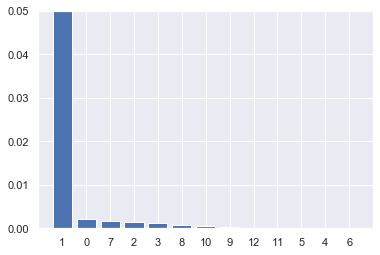

In [125]:
from mlxtend.evaluate import feature_importance_permutation
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, 
                                                    test_size=.20, random_state=42, 
                                                    stratify=y.values)
encoder = WOEEncoder()
scorecard = make_pipeline(objectify, encoder, clf)
scorecard.fit(X_train, y_train)
print("completed fit...")
imp_vals, _ = feature_importance_permutation(
    predict_method=scorecard.predict, 
    X=X_test,
    y=y_test,
    metric='accuracy',
    num_rounds=1,
    seed=1)

print(imp_vals)

indices = np.argsort(imp_vals)[::-1]
plt.figure()
plt.bar(range(X.shape[1]), imp_vals[indices])
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.ylim([0, 0.05])
plt.show()

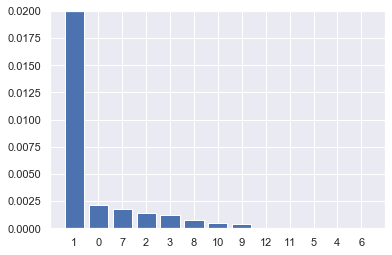

In [126]:
indices = np.argsort(imp_vals)[::-1]
plt.figure()
plt.bar(range(X.shape[1]), imp_vals[indices])
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.ylim([0, 0.02])
plt.show()

In [32]:
df[df['Arrest Flag']== 'Y'].groupby('Subject Age Group').count()

,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,...,subject_age_groups,stop_resolution,arrest_flag,weapon_present,officer_gender,officer_race,subject_race,subject_gender,stop_reso_arrest,hour
Subject Age Group,,,,,,,,,,,,,,,,,,,,,
-,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
1 - 17,33,33,33,33,33,33,33,33,33,33,...,33,33,33,33,33,33,33,33,33,33
18 - 25,208,208,208,208,208,208,208,208,208,208,...,208,208,208,208,208,208,208,208,208,208
26 - 35,496,496,496,496,496,496,496,496,496,496,...,496,496,496,496,496,496,496,496,496,496
36 - 45,363,363,363,363,363,363,363,363,363,363,...,363,363,363,363,363,363,363,363,363,363
46 - 55,185,185,185,185,185,185,185,185,185,185,...,185,185,185,185,185,185,185,185,185,185
56 and Above,74,74,74,74,74,74,74,74,74,74,...,74,74,74,74,74,74,74,74,74,74


In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.tree._tree import TREE_LEAF

In [34]:
def plot_tree(dt, used_cols, out_file='mytree.dot'):
    export_graphviz(dt, out_file=out_file, 
                    filled=True, feature_names=used_cols, 
                    leaves_parallel=True, node_ids=True, rotate=True)
    with open(out_file) as f:
        dot_graph = f.read()
    return graphviz.Source(dot_graph)
    

def prune_index(inner_tree, index, threshold):
    if inner_tree.value[index].min() < threshold:
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
    # if there are children, visit them as well
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_index(inner_tree, inner_tree.children_left[index], threshold)
        prune_index(inner_tree, inner_tree.children_right[index], threshold)

In [35]:
# used_cols = [c for c in df.columns if c not in excluded_cols]
used_cols = ['Final Call Type',
             'Subject Perceived Race',
#              'Officer ID',
             'hour',
             'Beat']

X = df[used_cols]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, 
                                                    test_size=.20, random_state=42, 
                                                    stratify=y.values)

dt = DecisionTreeClassifier(criterion='entropy',
                            max_depth=3,
                            min_samples_leaf=5,
                            random_state=42,
                            class_weight='balanced')

encoder = WOEEncoder()
scorecard = make_pipeline(objectify, encoder, dt)

scores = cross_val_score(scorecard, X, y, cv=5, scoring='accuracy')
print(scores.mean(), "+/-", scores.std())

0.7878782415248915 +/- 0.019492457187629004


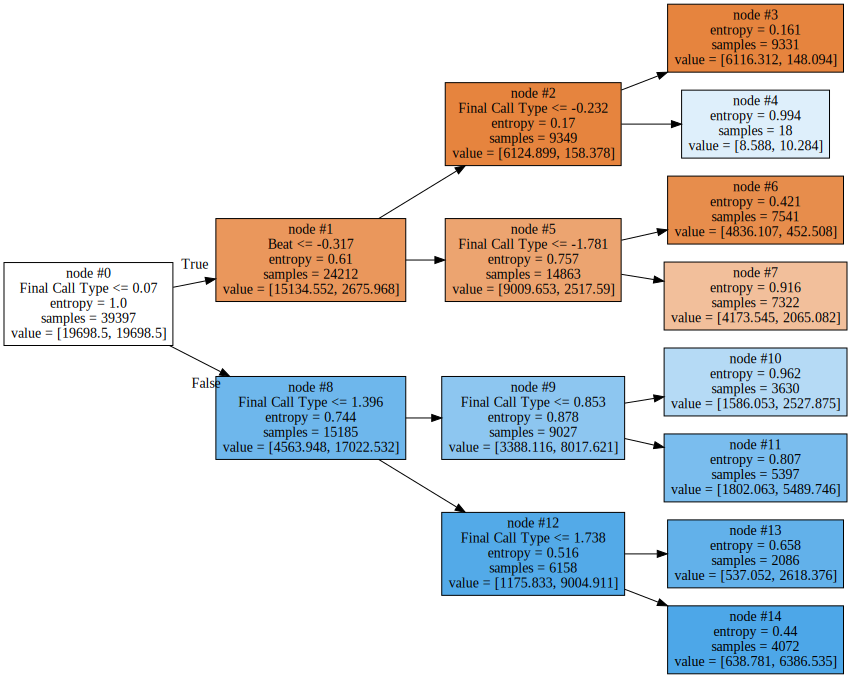

In [36]:
X_transformed = Pipeline(scorecard.steps[:-1]).fit_transform(X, y)
dt.fit(X_transformed, y)
plot_tree(dt, used_cols)

In [ ]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree_logic(data):")
    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if data['{}'] <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if data['{}'] > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))
    recurse(0, 1)

In [ ]:
tree_to_code(dt, used_cols)